# Tutorial for $n=5$ spin

In this notebook it is showed a step-by-step procedure for generating data, training models and compare exact results and predictions. We will concentrate on time-independent local generators for systems with periodic boundary conditions.
The first thing to do is to set-up the parameters in the headers of the code, keep in mind that the parameters used must be the same for all the steps (data generation, training, test).

## Data generation

The file for generating data is named ''create_data_thermal_PBC.py''. We set the sollowing parameters in the header:

default_parameters =  
                      
                      {'model_dir': './results/data_th_periodic/T_10',
                      'system': {
                      'n_spins': 5,  # system size
                      'beta': [0],
                      'potential': [0.1],
                      'Rabi': 1,
                      'Delta': 0,

                         },
                      'dt': 0.01,  # time step
                      'time': 10,  # total time of the evolution
                      'num_trajectories': 20,  # number
                      'seed': None
                      }"
 i.e. 20 trajectories (starting from 20 different initial states), $\beta=0$, $V=0.1\Omega$.

### Here the code

In [1]:
#You may need to install some libraries
#the usual procedure on terminal is (if you have anaconda, suggested)
#$ conda install -c conda-forge name_of_library (e.g. tensorboardx)
import scipy.sparse.linalg as spa
import scipy.sparse as sps
from ml.utils import update_params_from_cmdline, save_metrics_params, ensure_dir
import os
import deepdish as dd
from physics.FSS_dyn.ED_b import *



default_parameters = {'model_dir': './results/data_th_periodic/T_10', #folder where we want to save
                      'system': {
                          'n_spins': 5,  # system size
                           'beta': [0.1],
                           'potential': [0.1],
                           'Rabi': 1,
                           'Delta': 0,

                      },
                      'dt': 0.01,  # time step
                      'time': 10,  # total time of the evolution
                      'num_trajectories': 20,  # number
                      'seed': None
                      }

In [3]:
#**********  BASIC MATRIX DEFINITIONS  **********
#
#
#
sigma_x = np.array( [ [ 0. , 1. ] , [ 1. , 0. ] ] )
N = np.array( [ [ 0. , 0. ] , [ 0. , 1. ] ] )
sigma_z = np.array( [ [ 1. , 0. ] , [ 0. , -1. ] ] )
sigma_y = np.array([[0, -1j], [1j, 0]])
Pj = np.array( [ [ 1. , 0. ] , [ 0. , 0. ] ] )
nf = np.array([[1, 0],[0, 0]]) ###  local fermions number nf = 1-sz ###
Id = np.eye(2).astype(np.float64)

#THIS IS THE FUNCTION WHICH GENERATES THE TRAJECTORIES STARTING FROM RANDOM INITIAL STATES
def compute_traj(site, beta, dt, T):
    nstep = int(T / dt)
    H_Rabi_th = H1f(sigma_x, L - 1)
    H_Detuning_th = H1f(nf, L - 1)
    H_int_th = H2srdef(nf, nf, L - 1)
    H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
    bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )
    a = np.random.uniform(0,1)
    x = np.sqrt(np.random.uniform(0, a))
    y = np.sqrt(a - x**2) 
    rho_loc = 0.5*np.array( [ [ 1 , x + 1j*y ],  [   x - 1j*y, 1  ] ] )
    rho = sps.kron(rho_loc, bath)
    rho_in  = sps.csc_matrix(rho)
    
    O0 = one_F(Id, site, L)
    O1 = one_F(sigma_x, site, L)
    O2 = one_F(sigma_y, site, L)
    O3 = one_F(sigma_z, site, L)
    OId = ((O0.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    arr = [ [OId, Ox, Oy, Oz ]  ]
    print(arr)
    U = spa.expm( -1j * H * dt)
    U_dag = spa.expm( 1j * H * dt)
    temp = [ 0.0 ]
    for i in range( 1, nstep ):
        rho_in = ((U.dot(rho_in)).dot(U_dag) ) / (rho_in.diagonal().sum())
        Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
        Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
        Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real
        time = i * dt
        arr.append( [OId, Ox, Oy, Oz ] )
        temp.append( i * dt )
    print("finished Time = %s" % T)
    return np.asarray(arr[:-1]).astype(np.float32), \
           np.asarray(arr[1:]).astype(np.float32), \
           np.asarray(temp[:-1]).astype(np.float32), \
           np.expand_dims(np.asarray(arr[0]).astype(np.float32), 0), \
           np.expand_dims(np.asarray(arr[-1]).astype(np.float32), 0)

In [4]:
pauli_dict = {
    'X': sigma_x,
    'Y': sigma_y,
    'Z': sigma_z,
    'I': Id
}
names=['I','X','Y','Z']




In [15]:
def compute_traj2(sites, beta, dt, T):
    names_pauli2=[]
    paulis2=[]
    observables_dict={}
    nstep = int(T / dt)
    H_Rabi_th = H1f(sigma_x, L - 2)
    H_Detuning_th = H1f(nf, L - 2)
    H_int_th = H2srdef(nf, nf, L - 2)
    H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
    bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )
    #rho_loc = 0.25*np.identity(4)
    #p={}
    #s=0.
    rho_loc=np.array([np.random.normal() for i in range(16)]).reshape(4,4)+1j*np.array([np.random.normal() for i in range(16)]).reshape(4,4)
    rho_loc=rho_loc.dot(rho_loc.conjugate().transpose())
    rho_loc=rho_loc/rho_loc.trace()
    #for mu in names[1:]:
    #    for nu in names[1:]:
    #        p[mu+nu]=np.random.uniform(0,1)
    #        s+=p[mu+nu]*p[mu+nu]
    #for key in p.keys(): p[key]=(p[key]*np.sqrt(np.random.uniform(0,1)))/np.sqrt(s)
    #for mu in names[1:]:
    #    for nu in names[1:]:
    #        rho_loc = rho_loc +  p[mu+nu]*0.25*sps.kron(pauli_dict[mu], pauli_dict[nu])
    
    rho = sps.kron(rho_loc, bath)
    rho_in  = sps.csc_matrix(rho)
    for i in names: 
       # names_pauli2.append(i+str(sites[0])+'I'+str(sites[1]))
       # paulis2.append(one_F(pauli_dict[i],sites[0],L))
        for j in names:
            names_pauli2.append(i+str(sites[0])+j+str(sites[1]))
            paulis2.append(two_FF(pauli_dict[i],pauli_dict[j],sites[0],sites[1],L))
    #O0 = one_F(Id, site, L)
    #O1 = one_F(sigma_x, site, L)
    #O2 = one_F(sigma_y, site, L)
    #O3 = one_F(sigma_z, site, L)
    for i in range(len(names_pauli2)):
        observables_dict[names_pauli2[i]]=((paulis2[i].dot(rho_in).diagonal().sum())/ 
                                           rho_in.diagonal().sum()).real
    #OId = ((O0.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    arr = [[ observables_dict[key] for key in observables_dict.keys()  ][1:]]
    print(arr)
    #print(arr)
    U = spa.expm( -1j * H * dt)
    U_dag = spa.expm( 1j * H * dt)
    temp = [ 0.0 ]
    for i in range( 1, nstep ):
        rho_in = ((U.dot(rho_in)).dot(U_dag) ) / (rho_in.diagonal().sum())
        for k in range(len(names_pauli2)):
            observables_dict[names_pauli2[k]]=((paulis2[k].dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real
            #Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
            #Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
            #Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real
        time = i * dt
        arr.append( [ observables_dict[key] for key in observables_dict.keys()  ][1:] )
        temp.append( i * dt )
    print("finished Time = %s" % T)
    return np.asarray(arr[:-1]).astype(np.float32), \
           np.asarray(arr[1:]).astype(np.float32), \
           np.asarray(temp[:-1]).astype(np.float32), \
           np.expand_dims(np.asarray(arr[0]).astype(np.float32), 0), \
           np.expand_dims(np.asarray(arr[-1]).astype(np.float32), 0)

In [16]:
cfg = default_parameters
L = cfg["system"]["n_spins"]
Omega = cfg["system"]["Rabi"]
for k in range(len(cfg["system"]["potential"])):
    for j in range(len(cfg["system"]["beta"])):
        C_def = cfg["system"]["potential"][k]
        Delta = cfg["system"]["Delta"]
        beta = cfg["system"]["beta"][j]


        print("----Generating trajectories for impurity = %s and for beta = %s" % (C_def, beta))

        #BUILDING THE HAMILTONIAN
        
        H_Rabi = H1f(sigma_x, L)
        H_Detuning = H1f(nf, L)
        H_sr = H2srdef(nf, nf, L)
        H_sr1 = H1srdef(nf, nf, L)
        T = cfg["time"]
        dt = cfg["dt"]
        nstep = int(T/dt)
        
        #HERE WE SPECIFY THE SITE ON WHICH WE WANT TO MEASURE THE OBSERVABLES
        site = 1
        sites=[1,2]
    
        H = ( Omega/2 )*H_Rabi + Delta*H_Detuning + H_sr + C_def*H_sr1 
    
        ensure_dir(cfg["model_dir"])

        if cfg["seed"] is not None:
            np.random.seed(cfg["seed"])

        trajectories = {}
        trajectories['p_t1'] = None
        trajectories['p_t2'] = None
        trajectories['t'] = None

        trajectories_eval_fin = {}
        trajectories_eval_fin['p_0'] = None
        trajectories_eval_fin['p_T'] = None

        for i in range(cfg["num_trajectories"]):
            print(f"trajectory: {i}")
            random_state= np.random.randint(0, 2**L)
            #p_t1, p_t2, t, p_0, p_T = compute_traj(site, beta ,cfg["dt"], cfg["time"])
            p_t1, p_t2, t, p_0, p_T = compute_traj2(sites, beta ,cfg["dt"], cfg["time"])

            if trajectories['p_t1'] is None:
                trajectories['p_t1'] = p_t1
                trajectories['p_t2'] = p_t2
                trajectories['t'] = t
                trajectories_eval_fin['p_0'] = p_0
                trajectories_eval_fin['p_T'] = p_T
            else:
                trajectories['p_t1'] = np.concatenate((trajectories['p_t1'], p_t1), 0)
                trajectories['p_t2'] = np.concatenate((trajectories['p_t2'], p_t2), 0)
                trajectories['t'] = np.concatenate((trajectories['t'], t), 0)
                trajectories_eval_fin['p_0'] = np.concatenate((trajectories_eval_fin['p_0'], p_0), 0)
                trajectories_eval_fin['p_T'] = np.concatenate((trajectories_eval_fin['p_T'], p_T), 0)

        path = os.path.join(cfg["model_dir"], f"traj_{beta}_{C_def}.h5")
        path_eval_fin = os.path.join(cfg["model_dir"], f"traj_final_{beta}_{C_def}.h5")

        print([v.shape for k, v in trajectories.items()])
        print(f"saving to {path}")
        dd.io.save(path, trajectories)
        dd.io.save(path_eval_fin, trajectories_eval_fin)
        print("done")
        metrics = {'dummy': 0}

----Generating trajectories for impurity = 0.1 and for beta = 0.1
trajectory: 0
[[0.28106798253637866, -0.4187976870174218, 0.10438398118557884, -0.10916504625544501, -0.4760314916155223, -0.040894081656977305, 0.39064664614260247, -0.4734158142307445, -0.29209517075201863, 0.46049244761211217, -0.33781282908738663, -0.001260168053079977, 0.21057562683651812, 0.3277455849890535, 0.3899976890778893]]


/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


finished Time = 10
trajectory: 1
[[0.15666846637731757, -0.008415384900338047, 0.05569400572863817, -0.0005812436595596938, -0.10978000945182342, 0.15193545071913062, -0.20557744521896176, 0.2224748353512517, 0.3830012568046989, 0.03811990277259667, 0.23081031999808488, -0.15157200901066228, -0.5246507530648482, 0.16571821796244832, -0.34444400900622246]]
finished Time = 10
trajectory: 2
[[-0.148642888674275, -0.14834605883131163, -0.015381707417272086, -0.05781775652251819, -0.16526113419432056, 0.3512141269095142, 0.28046520779888073, -0.23557928526562938, 0.49365767375660397, 0.17300797772658266, -0.1655233620391668, -0.309179473447773, -0.03070323769328647, 0.005516859867437884, 0.2264340896710969]]
finished Time = 10
trajectory: 3
[[0.23334069973293237, 0.1798313596712039, 0.06146513681397796, 0.45129660973622454, 0.32888937673893315, 0.36139780626388407, 0.06780443343872965, 0.23145871779565969, 0.4348953658791587, -0.20545669163422764, -0.049949376246243134, 0.1440478198084521, 

Some warnings about sparse efficiency may occur, they do not inficiate the correctness of the data generation.

## Train, evaluate and save the model

In this case in the header we must also specify the value of the parameters (which will be used to call the datasets saved) and the architecture of the model. We must also specify: the number of epochs, the size of every batch and the number of batches per epoch. The file is named "train_PBC.py".

### Here the code

In [5]:
#SAME HERE YOU MAY NEED TO INSTALL SMTH
from ml.utils import update_params_from_cmdline, save_metrics_params, ensure_dir, ensure_empty_dir, infinite_dataset
from torch.utils.data import Dataset, DataLoader
from ml.pytorch_modules.vae import BVAE
from ml.pytorch_modules.dynamics_mlp import MLP, MLLP
from torch import optim
from train_data import *
from utils.settings import cfg
import os
from tensorboardX import SummaryWriter #This module enable to monitor, live, the training later we will show
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Parameters of the model
parameters = {'model_dir': './results/test1', #folder where the metadata of the training are stored, useful  for tensorboard
                      'n_spins': 5,
                      'batch_size': 256,
                      'batches_per_epoch': 256,
                      'n_epochs': 20,
                      'beta': [0.1],
                      'potential': [0.1],
                      'device': 'cpu',
                      'MLP_pr': {
                      'mlp_params': {
                          'data_dim': 15,
                          'layers': [],
                              'nonlin': 'id',
                              'output_nonlin': 'id'
                          },
                          },
                      }
conf = parameters
#In order to visualize the training live just type on the terminal "tensorboard --logdir=./results/test1" logdir is the model_dir

In [7]:
#**************** THIS DEFINES THE TRAINING PROCEDURE********************
def train(model, optimizer, data_loader, batches_per_epoch, epoch, writer):
    model.train()
    summed_train_loss = 0.
    for batch_idx in range(batches_per_epoch):
        (batch_in, batch_out) = next(data_loader)
        data_in = batch_in.float().to(conf['device'])
        data_out = batch_out.float().to(conf['device'])
        optimizer.zero_grad()
        recon_batch = model(data_in)
        loss = model.loss(data_out, recon_batch)
        summed_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        writer.add_scalar('train_loss', loss, batches_per_epoch * epoch + batch_idx)

    print('=== Mean train loss: {:.4f}'.format(summed_train_loss / batches_per_epoch))
    return model, optimizer

In [8]:
#**************** THIS DEFINES THE EVALUATION PROCEDURE********************

def eval(data_loader, model, batch_idx, writer):
    model.eval()
    summed_eval_loss = 0.
    summed_eval_test_loss = 0.
    batches_per_eval = 100
    for i in range(batches_per_eval):
        (batch_in, batch_out) = next(data_loader)
        data_in = batch_in.float().to(conf['device'])
        data_out = batch_out.float().to(conf['device'])
        recon_batch = model(data_in)
        eval_loss = model.loss(data_out, recon_batch).item()
        summed_eval_loss += eval_loss

    writer.add_scalar('eval_loss', summed_eval_loss / batches_per_eval, batch_idx)
    print('=== Test set loss: {:.4f}'.format(summed_eval_loss / batches_per_eval))
    return {'loss': summed_eval_loss}

In [9]:
conf = parameters
ensure_dir(conf['model_dir'])
ensure_empty_dir(conf['model_dir'])
for k in range(len(conf["beta"])):
    for j in range(len(conf["potential"])):
        beta = conf["beta"][k]
        C = conf["potential"][j]
        print('===Training model for beta = %s and C = %s' %(beta, C))
        data_train = Data_p_train("./results/data_th_periodic/T_10/traj_%s_%s.h5" %(beta, C))
        data_eval = Data_p_eval("./results/data_th_periodic/T_10/traj_%s_%s.h5" %(beta, C))
        train_loader = DataLoader(dataset=data_train, batch_size=conf['batch_size'], shuffle=True, num_workers=0)
        train_loader = infinite_dataset(train_loader)
        eval_loader = DataLoader(dataset=data_eval, batch_size=conf['batch_size'], shuffle=True, num_workers=0)
        eval_loader = infinite_dataset(eval_loader)
        writer = SummaryWriter(os.path.join(conf['model_dir'], 'tensorboard'))
        model = MLLP(**conf['MLP_pr']).to(conf['device'])
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        for epoch in range(conf['n_epochs']):
            print('= Starting epoch ', epoch, '/', conf['n_epochs'])
            model, optimizer = train(model, optimizer, train_loader, conf['batches_per_epoch'], epoch, writer)
            metrics = eval(eval_loader, model, conf['batches_per_epoch'] * epoch, writer)
        #save_metrics_params(metrics, conf)


        torch.save(model.state_dict(), './trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s' %(C, beta))

===Training model for beta = 0.1 and C = 0.1
= Starting epoch  0 / 20
=== Mean train loss: 0.0130
=== Test set loss: 0.0014
= Starting epoch  1 / 20
=== Mean train loss: 0.0004
=== Test set loss: 0.0001
= Starting epoch  2 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  3 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  4 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  5 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  6 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  7 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  8 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  9 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  10 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Starting epoch  11 / 20
=== Mean train loss: 0.0000
=== Test set loss: 0.0000
= Sta

Now, we saved the model in the path speficied by the command "torch.save()". Note that the path of the model is speficied also by the value of the parameters

## Test
We can test the model by loading it and compare the performace of exact evolution. Please keep in mind that in the header the parameters of the model must be the same used for the training. We will condiser $T_{max}>T_{train}$

### Here the code

In [19]:
## Parameters
L = 5
dt = 0.01
T = 20
nstep = int(T/dt)
Omega = 1.0
Delta = 0
C = 1
C_def = 0.1
sites = [1,2]
beta = 0.1

In [20]:
# Parameters of the header
default_parameters_test = {'device': 'cpu',
                      'MLP_par': {
                      		'mlp_params': {
                          		'data_dim': 15,
                          		'layers':  [ ],
                              'nonlin': 'id',
                              'output_nonlin': 'id'
                          					},
                          },
                      }

In [22]:

print("Building Hamiltonian for L=%s" %(L))

###### define local matrices#####


sigma_plus = np.array( [ [ 0. , 1. ] , [ 0. , 0. ] ] )
sigma_minus = np.array( [ [ 0. , 0. ] , [ 1. , 0. ] ] )
sigma_x = np.array([[0, 1], [1, 0]]) #### Rabi term####
sigma_z = np.array( [ [ 1. , 0. ] , [ 0. , -1. ] ] )
sigma_y = np.array([[0, 1j], [-1j, 0]])
Pj = np.array( [ [ 1. , 0. ] , [ 0. , 0. ] ] )
nf = np.array([[1, 0],[0, 0]]) ###  local fermions number nf = 1-sz ###
Id = np.eye(2)

#### Initial state ###
rho1 = np.array( [ [ 0.8 , 0 ],  [  0 , 0.2  ] ] ) #State of the sub-system
rho2 = np.array( [ [ 0.4 , 0 ],  [  0 , 0.6  ] ] )
rho = np.kron(rho1,rho2)
#rho=np.diag([0.05308175, 0.45636563, 0.37870432, 0.11184829])

red = rho/np.trace(rho)
#Thermal Hamiltonian for the sub-system with L - 1 sites
H_Rabi_th = H1f(sigma_x, L - 2)
H_Detuning_th = H1f(nf, L - 2)
H_int_th = H2srdef(nf, nf, L - 2)
H_th = ( Omega/2 )*H_Rabi_th + Delta*H_Detuning_th + H_int_th
#State of the bath
bath = (spa.expm( - beta * H_th))/( spa.expm(-beta * H_th ).diagonal().sum().real )
rho_in = sps.kron(red, bath)


#### Construction of the Hamiltonian ####

H_Rabi = H1f(sigma_x, L)

H_Detuning = H1f(nf, L)

H_sr = H2srdef(nf, nf, L)

H_sr1 = H1srdef(nf, nf, L)

H = ( Omega/2 )*H_Rabi + Delta*H_Detuning + C*H_sr + C_def*H_sr1 

U = spa.expm( -1j * H * dt)

U_dag = spa.expm( 1j * H * dt)

print("HAMILTONIAN BUILT")

#OBSERVABLES 
names_pauli2t=[]
paulis2t=[]


for i in names:
        for j in names:
            #names_pauli2t.append(i+str(sites[0])+'I'+str(sites[1]))
            #paulis2t.append(one_F(pauli_dict[i],sites[0],L))
            names_pauli2t.append(i+str(sites[0])+j+str(sites[1]))
            paulis2t.append(two_FF(pauli_dict[i],pauli_dict[j],sites[0],sites[1],L))
print(names_pauli2t   )         
#O0 = one_F(Id, site, L)
#O1 = one_F(sigma_x, site, L)
#O2 = one_F(sigma_y, site, L)
#O3 = one_F(sigma_z, site, L)
observables_dict_test={}
for i in range(len(names_pauli2t)):
        observables_dict_test[names_pauli2t[i]]=((paulis2t[i].dot(rho_in).diagonal().sum())/ 
                                           rho_in.diagonal().sum()).real
#OId = ((O0.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
#Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
#Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
#Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
v_in = torch.tensor([ observables_dict_test[key] for key in observables_dict_test.keys()  ][1:]).float()
print(v_in)
temp1 = [v_in.numpy()]
#v_in = torch.tensor([OId, Ox, Oy, Oz ]).float() #we must tensorize the input for feeding the NN
#temp1 = [v_in.numpy()[1:]]


conf = default_parameters_test
model = MLLP(**conf['MLP_par']).to(conf['device'])#we load the blueprint of the model
#we load the saved parameters for 1 site impurity
#model.load_state_dict(torch.load('./trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s' %(C_def, beta))) 

#Load the model for extended (2 sites) impurity
model.load_state_dict(torch.load('./trained_models/PBC/Thermal/eff__Cdef_%s_beta_%s' %(C_def, beta))) #we load the saved parameters




###### DYNAMICS ######


time = [ [0] ]
temp = [ [ observables_dict_test[key] for key in observables_dict_test.keys()  ][1:] ]
#der = 0

for i in range( 1, nstep ):

    print( 'Time = %.2f ' % (i * dt) )
    time +=  [ [ i * dt ] ]
    rho_in = ((U.dot(rho_in)).dot(U_dag) ) / (rho_in.diagonal().sum())
    #Evolution with Exact diagonalization
    for j in range(len(names_pauli2t)):
        observables_dict_test[names_pauli2t[j]]=((paulis2t[j].dot(rho_in).diagonal().sum())/ 
                                               rho_in.diagonal().sum()).real
    #Ox =  ((O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oy =  ((O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real
    temp.append( [ observables_dict_test[key] for key in observables_dict_test.keys()  ][1:] )

    #Evolution with Exact diagonalization
    #OId =  ((O0.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Ox =  (-(O1.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oy =  (-(O2.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #Oz =  ((O3.dot(rho_in).diagonal().sum())/ rho_in.diagonal().sum()).real 
    #temp.append( [ Ox, Oy, Oz  ] )
    #Evolution of the model
    with torch.no_grad():
      data_in = torch.tensor(time[i])
      v_out = model(v_in.float())
      v_in = v_out
      temp1.append(v_in.numpy()[1:])

Building Hamiltonian for L=5
HAMILTONIAN BUILT
['I1I2', 'I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']
tensor([ 0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.6000,  0.0000,  0.0000, -0.1200])
Time = 0.01 
Time = 0.02 
Time = 0.03 
Time = 0.04 
Time = 0.05 
Time = 0.06 
Time = 0.07 
Time = 0.08 
Time = 0.09 
Time = 0.10 
Time = 0.11 
Time = 0.12 
Time = 0.13 
Time = 0.14 
Time = 0.15 
Time = 0.16 
Time = 0.17 
Time = 0.18 
Time = 0.19 
Time = 0.20 
Time = 0.21 
Time = 0.22 
Time = 0.23 
Time = 0.24 
Time = 0.25 
Time = 0.26 
Time = 0.27 
Time = 0.28 
Time = 0.29 
Time = 0.30 
Time = 0.31 
Time = 0.32 
Time = 0.33 
Time = 0.34 
Time = 0.35 
Time = 0.36 
Time = 0.37 
Time = 0.38 
Time = 0.39 
Time = 0.40 
Time = 0.41 
Time = 0.42 
Time = 0.43 
Time = 0.44 
Time = 0.45 
Time = 0.46 
Time = 0.47 
Time = 0.48 
Time = 0.49 
Time = 0.50 
Time = 0.51 
Time = 0.

Time = 6.11 
Time = 6.12 
Time = 6.13 
Time = 6.14 
Time = 6.15 
Time = 6.16 
Time = 6.17 
Time = 6.18 
Time = 6.19 
Time = 6.20 
Time = 6.21 
Time = 6.22 
Time = 6.23 
Time = 6.24 
Time = 6.25 
Time = 6.26 
Time = 6.27 
Time = 6.28 
Time = 6.29 
Time = 6.30 
Time = 6.31 
Time = 6.32 
Time = 6.33 
Time = 6.34 
Time = 6.35 
Time = 6.36 
Time = 6.37 
Time = 6.38 
Time = 6.39 
Time = 6.40 
Time = 6.41 
Time = 6.42 
Time = 6.43 
Time = 6.44 
Time = 6.45 
Time = 6.46 
Time = 6.47 
Time = 6.48 
Time = 6.49 
Time = 6.50 
Time = 6.51 
Time = 6.52 
Time = 6.53 
Time = 6.54 
Time = 6.55 
Time = 6.56 
Time = 6.57 
Time = 6.58 
Time = 6.59 
Time = 6.60 
Time = 6.61 
Time = 6.62 
Time = 6.63 
Time = 6.64 
Time = 6.65 
Time = 6.66 
Time = 6.67 
Time = 6.68 
Time = 6.69 
Time = 6.70 
Time = 6.71 
Time = 6.72 
Time = 6.73 
Time = 6.74 
Time = 6.75 
Time = 6.76 
Time = 6.77 
Time = 6.78 
Time = 6.79 
Time = 6.80 
Time = 6.81 
Time = 6.82 
Time = 6.83 
Time = 6.84 
Time = 6.85 
Time = 6.86 
Time = 6.87 

Time = 12.44 
Time = 12.45 
Time = 12.46 
Time = 12.47 
Time = 12.48 
Time = 12.49 
Time = 12.50 
Time = 12.51 
Time = 12.52 
Time = 12.53 
Time = 12.54 
Time = 12.55 
Time = 12.56 
Time = 12.57 
Time = 12.58 
Time = 12.59 
Time = 12.60 
Time = 12.61 
Time = 12.62 
Time = 12.63 
Time = 12.64 
Time = 12.65 
Time = 12.66 
Time = 12.67 
Time = 12.68 
Time = 12.69 
Time = 12.70 
Time = 12.71 
Time = 12.72 
Time = 12.73 
Time = 12.74 
Time = 12.75 
Time = 12.76 
Time = 12.77 
Time = 12.78 
Time = 12.79 
Time = 12.80 
Time = 12.81 
Time = 12.82 
Time = 12.83 
Time = 12.84 
Time = 12.85 
Time = 12.86 
Time = 12.87 
Time = 12.88 
Time = 12.89 
Time = 12.90 
Time = 12.91 
Time = 12.92 
Time = 12.93 
Time = 12.94 
Time = 12.95 
Time = 12.96 
Time = 12.97 
Time = 12.98 
Time = 12.99 
Time = 13.00 
Time = 13.01 
Time = 13.02 
Time = 13.03 
Time = 13.04 
Time = 13.05 
Time = 13.06 
Time = 13.07 
Time = 13.08 
Time = 13.09 
Time = 13.10 
Time = 13.11 
Time = 13.12 
Time = 13.13 
Time = 13.14 
Time =

Time = 18.39 
Time = 18.40 
Time = 18.41 
Time = 18.42 
Time = 18.43 
Time = 18.44 
Time = 18.45 
Time = 18.46 
Time = 18.47 
Time = 18.48 
Time = 18.49 
Time = 18.50 
Time = 18.51 
Time = 18.52 
Time = 18.53 
Time = 18.54 
Time = 18.55 
Time = 18.56 
Time = 18.57 
Time = 18.58 
Time = 18.59 
Time = 18.60 
Time = 18.61 
Time = 18.62 
Time = 18.63 
Time = 18.64 
Time = 18.65 
Time = 18.66 
Time = 18.67 
Time = 18.68 
Time = 18.69 
Time = 18.70 
Time = 18.71 
Time = 18.72 
Time = 18.73 
Time = 18.74 
Time = 18.75 
Time = 18.76 
Time = 18.77 
Time = 18.78 
Time = 18.79 
Time = 18.80 
Time = 18.81 
Time = 18.82 
Time = 18.83 
Time = 18.84 
Time = 18.85 
Time = 18.86 
Time = 18.87 
Time = 18.88 
Time = 18.89 
Time = 18.90 
Time = 18.91 
Time = 18.92 
Time = 18.93 
Time = 18.94 
Time = 18.95 
Time = 18.96 
Time = 18.97 
Time = 18.98 
Time = 18.99 
Time = 19.00 
Time = 19.01 
Time = 19.02 
Time = 19.03 
Time = 19.04 
Time = 19.05 
Time = 19.06 
Time = 19.07 
Time = 19.08 
Time = 19.09 
Time =

## Plot the results

In [56]:
temp_free

[[0.0,
  0.0,
  -0.1999999999999999,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.6000000000000001,
  0.0,
  0.0,
  -0.11999999999999994],
 [-5.799895597489546e-06,
  0.0019999470672019907,
  -0.1999900001323323,
  2.6999833404830554e-06,
  -1.0041322241774625e-11,
  9.998554004580555e-10,
  9.000098513673976e-07,
  -0.005999898700511786,
  3.4665530745684797e-08,
  -1.1999483634310993e-05,
  0.0011999207018960358,
  0.5999700002532492,
  -3.799765602619269e-06,
  0.0011999070690624602,
  -0.11998800043057611],
 [-2.31983296058297e-05,
  0.003999576550463413,
  -0.19996000211727605,
  1.0799733445544409e-05,
  -1.6064462385498865e-10,
  7.995373077135057e-09,
  3.6001575965892975e-06,
  -0.011999189616377068,
  2.772969854455972e-07,
  -4.7991738595885666e-05,
  0.0023993656606709104,
  0.5998800040519454,
  -1.519624986752329e-05,
  0.0023992566099957243,
  -0.11995200688887543],
 [-5.219154401759352e-05,
  0.005998570930077443,
  -0.19991001071834955,
  2.4298650549640

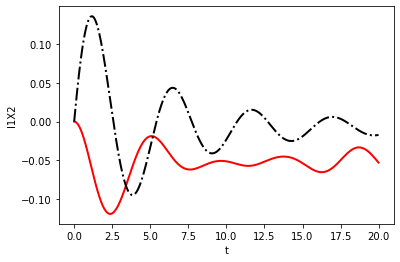

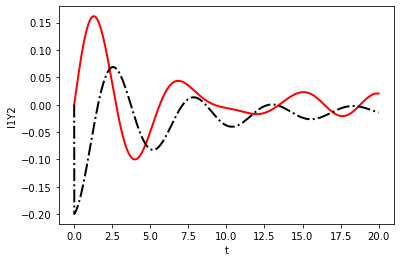

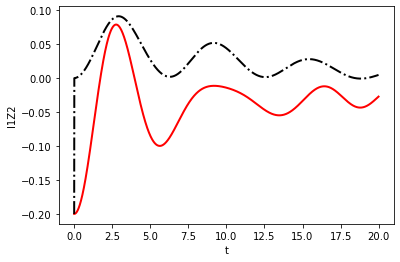

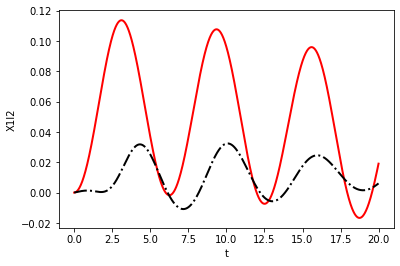

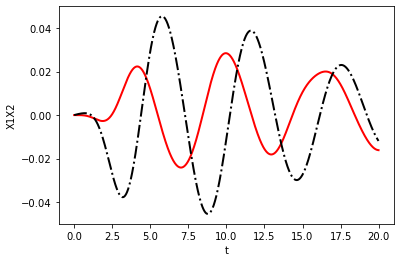

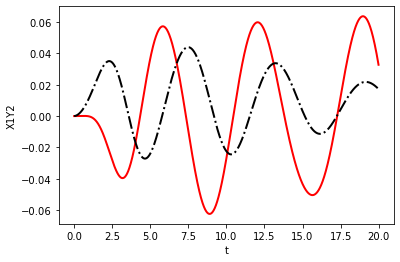

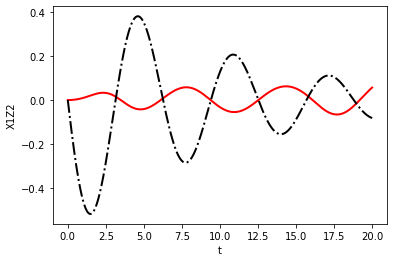

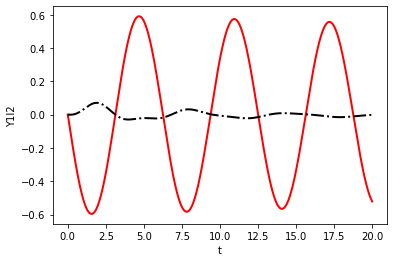

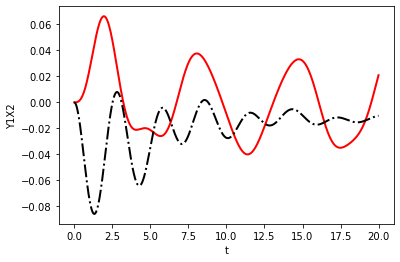

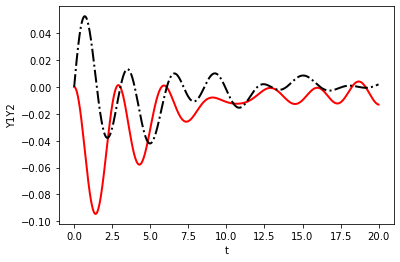

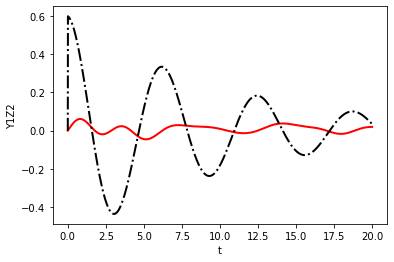

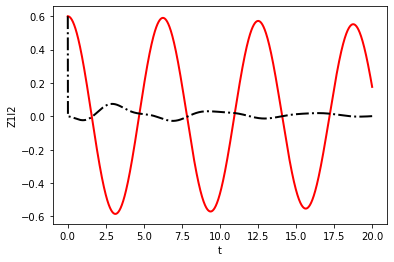

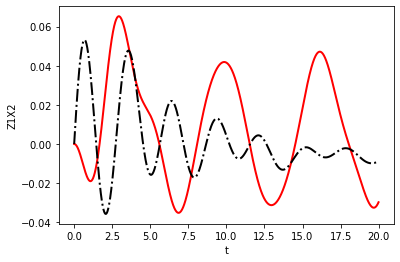

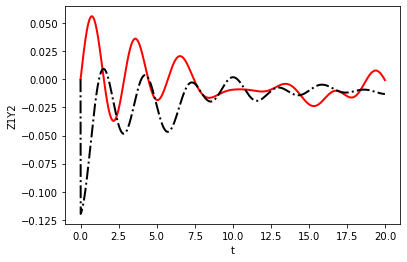

IndexError: index 14 is out of bounds for axis 0 with size 14

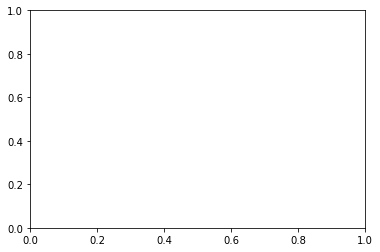

In [23]:

for i in range(15):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x3=[x[i] for x in temp]
    x31=[x[i] for x in temp1]
    ax.plot(time, x3, 'r-', linewidth=2)
    ax.plot(time, x31, 'k-.', linewidth=2)
    ax.set_xlabel('t')
    ax.set_ylabel(names_pauli2t[i+1])
    plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, temp, 'r-', linewidth=2)
ax.plot(time, temp1, 'k-.', linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel(names_pauli2t[i+1])
plt.show()

    
    

# 